# **Análisis de la temporada 2019-2020 de la NBA para LAL, LAC, DEN, HOU.** 
---
<img src="logoNBA.png" width=700 height=900 /> </img>

## Importando librerias y cargando los datos a usar obtenidos en https://www.kaggle.com/schmadam97/nba-playbyplay-data-20182019?select=NBA_PBP_2019-20.csv

In [1]:
import numpy as np #Librería numérica
import pandas as pd #librería para el análisis y manipulación de datos
import matplotlib.pyplot as plt #Librería gráfica
import seaborn as sns #Librería gráfica de complementación

In [2]:
df_original=pd.read_csv('NBA_PBP_2019-20.csv') # Archivo descargado previamente en el pc

### Definiendo unas funciones que serán de utilidad después a la hora de graficar:

In [163]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 -0.07
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() +2
            ax.annotate(percentage, (x, y), size = 14)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() +5
        ax.annotate(percentage, (x, y), size = 14)
    plt.show()

### Viendo información y las columnas del DataFrame original:

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539265 entries, 0 to 539264
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   URL                 539265 non-null  object 
 1   GameType            539265 non-null  object 
 2   Location            539265 non-null  object 
 3   Date                539265 non-null  object 
 4   Time                539265 non-null  object 
 5   WinningTeam         539265 non-null  object 
 6   Quarter             539265 non-null  int64  
 7   SecLeft             539265 non-null  int64  
 8   AwayTeam            539265 non-null  object 
 9   AwayPlay            272389 non-null  object 
 10  AwayScore           539265 non-null  int64  
 11  HomeTeam            539265 non-null  object 
 12  HomePlay            266868 non-null  object 
 13  HomeScore           539265 non-null  int64  
 14  Shooter             202397 non-null  object 
 15  ShotType            202397 non-nul

### Dado a que cada evento es único se procede a eliminar las filas que sean completamente iguales debido a posibles errores de digitación:

In [4]:
df_sin_duplicados= df_original.drop_duplicates()

### Selecionando solamente los partidos regulares y las columnas necesarias para el análisis:

In [5]:
df_sin_duplicados=df_sin_duplicados[df_sin_duplicados['GameType']=='regular']

Columnas = ['Date','WinningTeam','Quarter','SecLeft','AwayTeam','AwayPlay','AwayScore',
            'HomeTeam','HomePlay','HomeScore','ShotType','ShotOutcome','ShotDist']

df=df_sin_duplicados[Columnas] 
df=df.reset_index()
df=df.drop(columns=['index'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500291 entries, 0 to 500290
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         500291 non-null  object 
 1   WinningTeam  500291 non-null  object 
 2   Quarter      500291 non-null  int64  
 3   SecLeft      500291 non-null  int64  
 4   AwayTeam     500291 non-null  object 
 5   AwayPlay     252693 non-null  object 
 6   AwayScore    500291 non-null  int64  
 7   HomeTeam     500291 non-null  object 
 8   HomePlay     247590 non-null  object 
 9   HomeScore    500291 non-null  int64  
 10  ShotType     188268 non-null  object 
 11  ShotOutcome  188268 non-null  object 
 12  ShotDist     188268 non-null  float64
dtypes: float64(1), int64(4), object(8)
memory usage: 49.6+ MB


### Se ve entonces que se pasaron de tener 539265 a 500291 filas y 13 columnas.
### Ahora, asignando 1 cuando gana LAL y 0 al caso contrario:

In [7]:
df['WinningTeam'].replace({'LAL': 1, 'LAC': 0}, inplace=True)
df['WinningTeam'].replace({'DEN': 0, 'HOU': 0}, inplace=True)

# Categorizando 

## Los Angeles Lakers (LAL) de local:

In [8]:
dfl_LAL=df[df['HomeTeam']=='LAL']
dfv_LAC=df[df['AwayTeam']=='LAC']
dfv_DEN=df[df['AwayTeam']=='DEN']
dfv_HOU=df[df['AwayTeam']=='HOU']

dfl_LAL_LAC=pd.merge(dfl_LAL, dfv_LAC, how='inner')
dfl_LAL_DEN=pd.merge(dfl_LAL, dfv_DEN, how='inner')
dfl_LAL_HOU=pd.merge(dfl_LAL, dfv_HOU, how='inner')

dfL_LAL1=pd.concat([dfl_LAL_LAC,dfl_LAL_DEN])
dfL_LAL=pd.concat([dfL_LAL1,dfl_LAL_HOU])

num_local=dfL_LAL['Date'].nunique()
print(f'Hubieron en total {num_local} partidos donde LAL fue local')

Hubieron en total 5 partidos donde LAL fue local


### Probabilidad de que LAL gane de local:

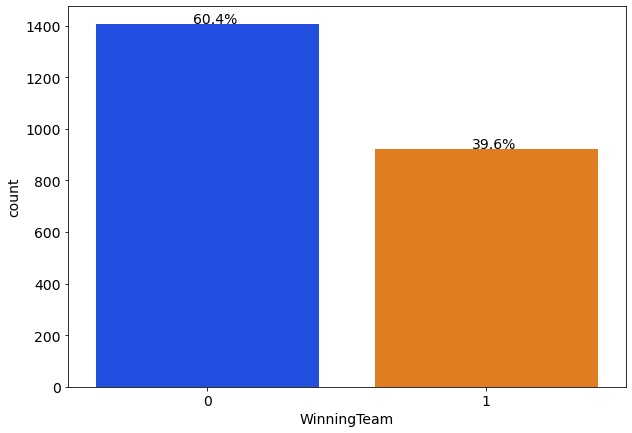

In [166]:
P_W_L=np.round(dfL_LAL['WinningTeam'].mean(),3) 

plt.figure(figsize=(10,7))
ax=sns.countplot(x='WinningTeam',data=dfL_LAL,palette='bright')
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('count',size=14)
plt.xlabel('WinningTeam',size=14)
without_hue(ax,dfL_LAL.WinningTeam)

### Cestas hechas y erradas de los equipos visitantes:

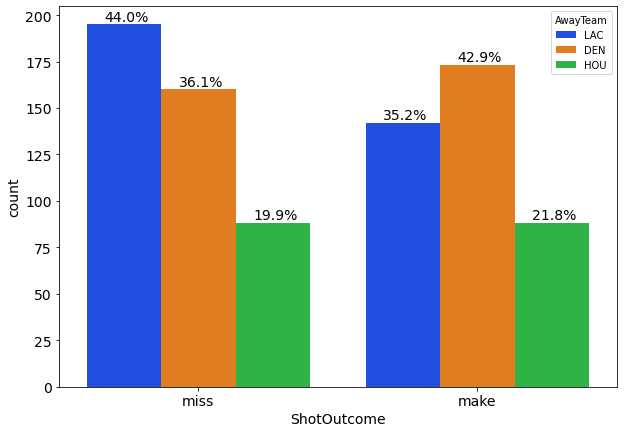

In [159]:
plt.figure(figsize=(10,7))
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='AwayTeam',palette='bright')
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('count',size=14)
plt.xlabel('ShotOutcome',size=14)
with_hue(ax,dfL_LAL.ShotOutcome,2,3)

### Probabilidad de acierto en cestas:

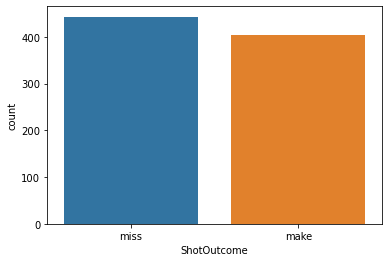

In [111]:
sns.countplot(x='ShotOutcome',data=dfL_LAL);

## Los Angeles Lakers (LAL) de visitante:

In [168]:
dfv_LAL=df[df['AwayTeam']=='LAL']
dfl_LAC=df[df['HomeTeam']=='LAC']
dfl_DEN=df[df['HomeTeam']=='DEN']
dfl_HOU=df[df['HomeTeam']=='HOU']

dfv_LAL_LAC=pd.merge(dfv_LAL, dfl_LAC, how='inner')
dfv_LAL_DEN=pd.merge(dfv_LAL, dfl_DEN, how='inner')
dfv_LAL_HOU=pd.merge(dfv_LAL, dfl_HOU, how='inner')

dfV_LAL1=pd.concat([dfv_LAL_LAC,dfv_LAL_DEN])
dfV_LAL=pd.concat([dfV_LAL1,dfv_LAL_HOU])

num_visitante=dfV_LAL['Date'].nunique()
print(f'Hubieron en total {num_visitante} partidos donde LAL fue visitante')

Hubieron en total 6 partidos donde LAL fue visitante


### Probabilidad de que LAL gane de visitante:

0.6793737236215113


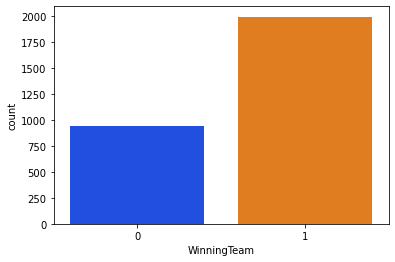

In [64]:
P_W_V=dfV_LAL['WinningTeam'].mean() 
print(P_W_V)
sns.countplot(x='WinningTeam',data=dfV_LAL,palette='bright'); # Recuerde que 1 corresponde a LAL

### Cestas hechas y erradas de los equipos locales:

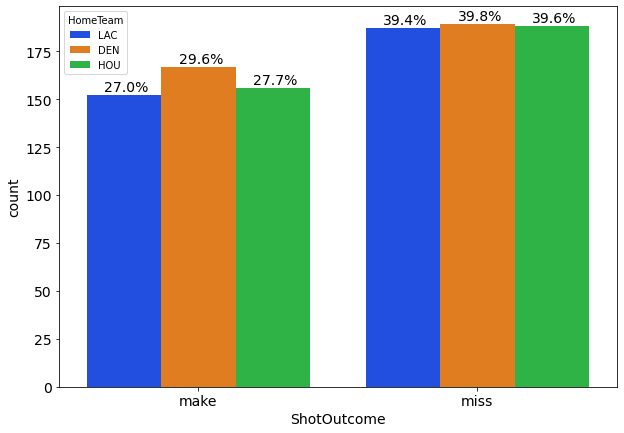

In [173]:
plt.figure(figsize=(10,7))
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='HomeTeam',palette='bright')
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('count',size=14)
plt.xlabel('ShotOutcome',size=14)
with_hue(ax,dfV_LAL.ShotOutcome,2,3)

## Partidos totales de LAL:

In [10]:
df_LAL=pd.concat([dfL_LAL,dfV_LAL])
df_LAL=df_LAL.reset_index()  #redefiniendo la cuenta del índice de cada fila
df_LAL=df_LAL.drop(columns=['index'])
num=df_LAL['Date'].nunique()
df_LAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5265 entries, 0 to 5264
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5265 non-null   object 
 1   WinningTeam  5265 non-null   object 
 2   Quarter      5265 non-null   int64  
 3   SecLeft      5265 non-null   int64  
 4   AwayTeam     5265 non-null   object 
 5   AwayPlay     2710 non-null   object 
 6   AwayScore    5265 non-null   int64  
 7   HomeTeam     5265 non-null   object 
 8   HomePlay     2554 non-null   object 
 9   HomeScore    5265 non-null   int64  
 10  ShotType     1885 non-null   object 
 11  ShotOutcome  1885 non-null   object 
 12  ShotDist     1885 non-null   float64
dtypes: float64(1), int64(4), object(8)
memory usage: 534.9+ KB


### Probabilidad de que en general LAL gane:

0.5542260208926876


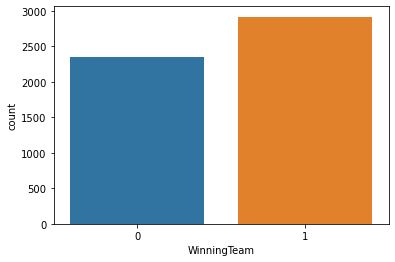

In [49]:
P_W=df_LAL['WinningTeam'].mean()
print(P_W)
sns.countplot(x='WinningTeam',data=df_LAL); # Recuerde que 1 corresponde a LAL

## Por ejemplo, viendo las cestas hechas  

### LAL de locales:

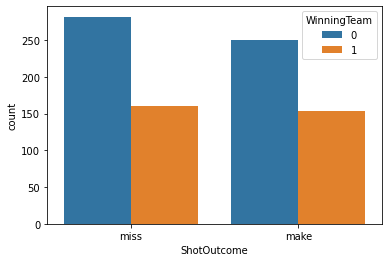

In [51]:
sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='WinningTeam');

### LAL de visitantes:

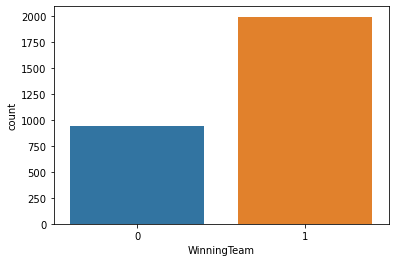

In [32]:
sns.countplot(x='WinningTeam',data=dfV_LAL);

## En general:

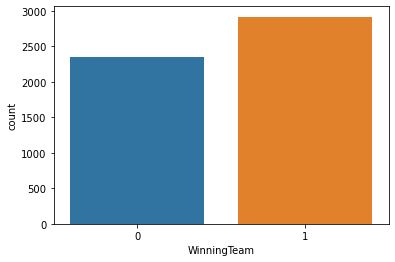

In [15]:
sns.countplot(x='WinningTeam',data=df_LAL);

In [16]:
df_LAL['WinningTeam'].value_counts()

1    2918
0    2347
Name: WinningTeam, dtype: int64

In [17]:
df_LAL['Date'].unique()

array(['December 25 2019', 'July 30 2020', 'December 22 2019',
       'August 10 2020', 'February 6 2020', 'October 22 2019',
       'March 8 2020', 'December 3 2019', 'February 12 2020',
       'January 18 2020', 'August 6 2020'], dtype=object)

In [174]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")


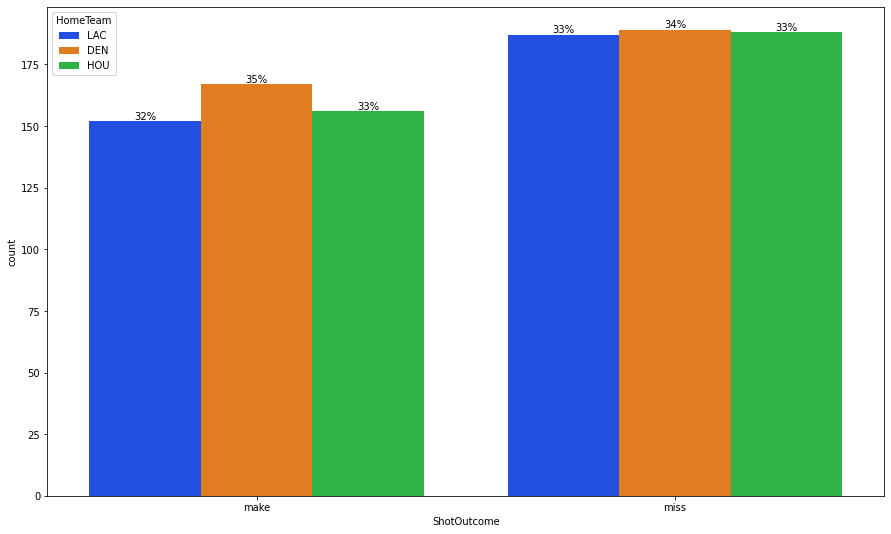

In [176]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfV_LAL,hue='HomeTeam',palette='bright')
barPerc(dfV_LAL,'ShotOutcome',ax)

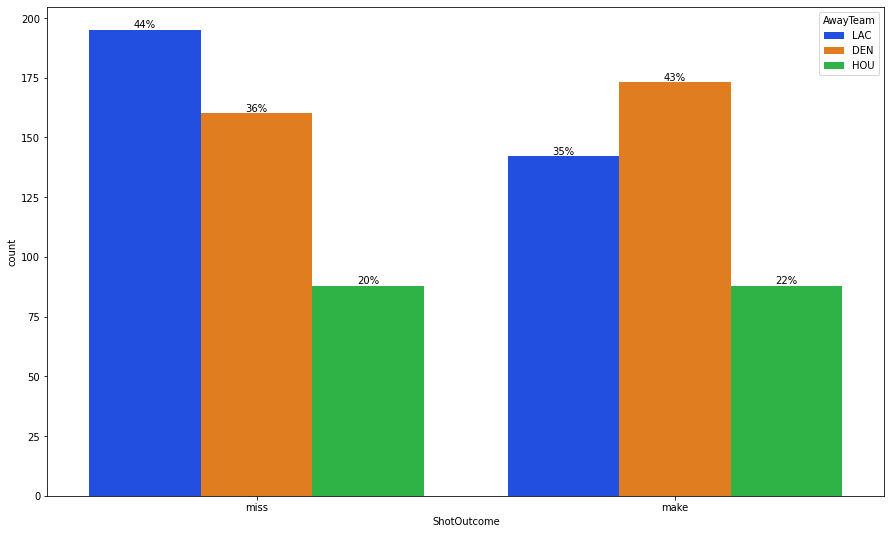

In [179]:
plt.figure(figsize=[15,9])
ax=sns.countplot(x='ShotOutcome',data=dfL_LAL,hue='AwayTeam',palette='bright')
barPerc(dfL_LAL,'ShotOutcome',ax)